Study of the CMS distribution

In [2]:
trgMu_pt_region = 'mid'

# Import

In [3]:
import sys, os, pickle
from glob import glob
sys.path.append('../lib')
import itertools
import json
from IPython.display import IFrame, Image, display
from multiprocessing import Pool

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import plot_gridVarQ2
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [5]:
m_mu = 0.10565837 #1e-3*Particle.from_string('D0').mass
print m_mu
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_D0 = 1.86962
m_pi = 0.13957018

0.10565837
2.01026
5.27963


In [6]:
col_dic = {'mu': rt.kAzure+1, 'tau': rt.kRed-4, 'Hc':rt.kGreen+1, 'Dstst': rt.kViolet-7}

# Define binning

In [7]:
binning = {
    'q2'      : array('d', [-2, 1.5, 4, 6, 12]),
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.8, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 1.6, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.2, 0.4)) + [6] ),
    ],
    'Est_mu'  : [
        array('d', [0.5] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.5] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.50, 2.500],
        [20, 0.50, 2.500],
    ]
}

# Create histograms file

In [8]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Hc'   : '../data/cmsMC_private/BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Dstst': '../data/cmsMC_private/BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root'
}

In [9]:
def trigger_selection(ev):        
    if trgMu_pt_region == 'high':
        aux = ev.trgMu_HLT_Mu12_IP6 == 1
        aux &= ev.trgMu_pt > 12.1
    elif trgMu_pt_region == 'mid':
        aux = ev.trgMu_HLT_Mu12_IP6 == 0
        aux &= ev.trgMu_HLT_Mu9_IP6 == 1
        aux &= ev.trgMu_pt > 9.1
        aux &= ev.trgMu_pt < 11.9
    
    aux &= abs(ev.trgMu_eta) < 2.4
    aux &= ev.trgMu_sigdxy > 7
    return aux

In [10]:
def candidate_selection(j, ev):
    aux = ev.pval_piK[j] > 0.1
    aux &= ev.K_pt[j] > 0.8
    aux &= abs(ev.K_eta[j]) < 2.5
    aux &= ev.pi_pt[j] > 0.8
    aux &= abs(ev.pi_eta[j]) < 2.5
    aux &= abs(ev.mass_piK[j] - 1.86) < 0.04
    if not aux: 
        return False

    aux = ev.pis_pt[j] > 0.5
    aux &= abs(ev.pis_eta[j]) < 2.5
    aux &= ev.pval_D0pis[j] > 0.1
    aux &= abs(ev.mass_D0pis[j] - 2.01) < 0.03
    aux &= ev.sigdxy_pis_PV[j] > 2
    aux &= ev.mass_D0pis[j] < ev.mass_piK[j] + 0.16
    aux &= ev.pval_D0pismu[j] > 0.1
    aux &= ev.cos_D0pismu_PV[j] > 0.99
    aux &= ev.q2_D0pismu[j] > binning['q2'][0]
    aux &= ev.q2_D0pismu[j] < binning['q2'][-1]
    aux &= ev.mass_D0pismu[j] < 7.
    if not aux: 
        return False
    
    if not ev.nTksAdd[j] == 0:
        idx_st = int(np.sum(ev.nTksAdd[:j]))
        # DEBUG controlla questa linea la prossima volta che fai le ntuple
        idx_stop = min(ev.tksAdd_massVis.size(), int(idx_st + ev.nTksAdd[j]))
        for jj in range(idx_st, idx_stop):
            if ev.tksAdd_massVis[jj] < 5.28:
                return False
    
    return True

In [85]:
def create_dSet(inputs, serial=False):
    n = inputs[0]
    filepath = inputs[1]
#     dSet = inputs[2]
    
    print n
    fskimmed_name = '../tmp/' + n + '_MC.root'
    if os.path.isfile(fskimmed_name) and not n in recreate:
        dSet[n] = rtnp.root2array(fskimmed_name)
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        N_cand_in = tree.GetEntries()
        print n, ': Number of candidate events:', N_cand_in
    
        if serial:
            pb = ProgressBar(maxEntry=tree.GetEntries())
        else:
            maxEntry = float(tree.GetEntries())
            perc = int(maxEntry*0.1)
        N_accepted_cand = []
        output = []
        for i_ev, ev in enumerate(tree):
            if serial:
                pb.show(i_ev)
            elif i_ev % perc == 0:
                print n, ': {:.0f}%'.format(100*(i_ev+1)/maxEntry)
            N_acc = 0
            
            if not trigger_selection(ev): 
                continue
                
            for j in range(ev.pval_piK.size()):
                if not candidate_selection(j, ev):
                    continue
                    
                N_acc += 1
                aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j])
                aux += (ev.MC_q2, ev.MC_Est_mu, ev.MC_M2_miss)
                aux += (ev.trgMu_pt, ev.trgMu_sigdxy)
                aux += (ev.B_D0pismu_pt[j], ev.B_D0pismu_eta[j], ev.B_D0pismu_phi[j])

                aux += (ev.MC_B_pt, ev.MC_B_eta, ev.MC_B_phi)
                aux += (ev.MC_Dst_pt, ev.MC_Dst_eta, ev.MC_Dst_phi)
                aux += (ev.MC_mu_pt, ev.MC_mu_eta, ev.MC_mu_phi)
                aux += (ev.D0_refitD0pismu_pt[j], ev.D0_refitD0pismu_eta[j], ev.D0_refitD0pismu_phi[j])
                aux += (ev.mu_refitD0pismu_pt[j], ev.mu_refitD0pismu_eta[j], ev.mu_refitD0pismu_phi[j])
                aux += (ev.pis_refitD0pismu_pt[j], ev.pis_refitD0pismu_eta[j], ev.pis_refitD0pismu_phi[j])
                if n in ['tau', 'mu']:
                    aux += (
                           ev.wh_CLNCentral,
                           ev.wh_CLNR0Down,
                           ev.wh_CLNR0Up,
                           ev.wh_CLNR1Down,
                           ev.wh_CLNR1Up,
                           ev.wh_CLNR2Down,
                           ev.wh_CLNR2Up,
                           ev.wh_CLNRhoSqDown,
                           ev.wh_CLNRhoSqUp,
                    )
                output.append(aux)
            
            if N_acc > 0:
                N_accepted_cand.append(N_acc)
        
        print n, ': Loop done'
        leafs_names = ['q2', 'Est_mu', 'M2_miss']
        leafs_names += ['MC_q2', 'MC_Est_mu', 'MC_M2_miss']
        leafs_names += ['trgMu_pt', 'trgMu_sigdxy']
        leafs_names += ['B_pt', 'B_eta', 'B_phi']
        leafs_names += ['MC_B_pt', 'MC_B_eta', 'MC_B_phi']
        leafs_names += ['MC_Dst_pt', 'MC_Dst_eta', 'MC_Dst_phi']
        leafs_names += ['MC_mu_pt', 'MC_mu_eta', 'MC_mu_phi']
        leafs_names += ['D0_pt', 'D0_eta', 'D0_phi']
        leafs_names += ['mu_pt', 'mu_eta', 'mu_phi']
        leafs_names += ['pis_pt', 'pis_eta', 'pis_phi']
        if n in ['tau', 'mu']:
            leafs_names += ['wh_CLNCentral', 'wh_CLNR0Down', 'wh_CLNR0Up', 'wh_CLNR1Down', 'wh_CLNR1Up', 'wh_CLNR2Down', 'wh_CLNR2Up', 'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']

        dtypes = []
        for nl in leafs_names:
            dtypes.append((nl, np.float32))
            
        dSet[n] = np.array(output, dtype=dtypes)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dSet[n], fskimmed_name, treename='Tevts', mode='RECREATE')
        
    aux = dSet[n].dtype.fields.keys()[0]
    print n, ': Events:', dSet[n][aux].shape[0]
    print ''

In [86]:
dSet = {}
recreate = file_loc.keys()
inputs = [[n, fp] for n, fp in file_loc.iteritems()]

# p = Pool(len(inputs))
# out = p.map(create_dSet, inputs) 

for i in inputs:
    create_dSet(i, serial=True)

mu
mu : Number of candidate events: 220152
[####################]  100% - Tot. time: 61.9 s
mu : Loop done
mu : Events: 22654

tau
tau : Number of candidate events: 48258
[####################]  100% - Tot. time: 16.9 s
tau : Loop done
tau : Events: 5572

Dstst
Dstst : Number of candidate events: 85378
[####################]  100% - Tot. time: 24.0 s
Dstst : Loop done
Dstst : Events: 2237

Hc
Hc : Number of candidate events: 34684
[####################]  100% - Tot. time: 11.3 s
Hc : Loop done
Hc : Events: 2709



Error in <TChain::LoadTree>: Cannot find tree with name outA/Tevts in file ../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_420.root
Error in <TChain::LoadTree>: Cannot find tree with name outA/Tevts in file ../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_489.root


In [17]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
fname = '../data/calibration/B02JPsiKst_Mu12_pt.txt'
if trgMu_pt_region == 'mid':
    fname = '../data/calibration/B02JPsiKst_Mu9_pt.txt'
cal_pT = PTCalibration(calibration_file=fname)

In [19]:
class LorentzVector(object):
    def __init__(self):
        pass
    
    def From_p4(self, p4):
        self.p4 = p4
        return self
    
    def From_dSet(self, d, tag, mass):
        self.mass = mass
        px = d[tag+'_pt']*np.cos(d[tag+'_phi'])
        py = d[tag+'_pt']*np.sin(d[tag+'_phi'])
        pz = d[tag+'_pt']*np.sinh(d[tag+'_eta'])
        e = np.hypot(mass, d[tag+'_pt']*np.cosh(d[tag+'_eta']))
        self.p4 = np.column_stack((e, px, py, pz))
        return self
        
    def P(self):
        return np.sqrt(np.sum(np.square(self.p4[:, 1:]), axis=-1))
    
    def Pt(self):
        return np.hypot(self.p4[:, 2], self.p4[:, 1])
    
    def Pz(self):
        return self.p4[:, 3]
    
    def M(self):
        e2 = np.square(self.p4[:,0])
        p2 = np.sum(np.square(self.p4[:, 1:]), axis=-1)
        return np.sqrt(e2 - p2)
    
    def Boost(self, LL):
        new = LorentzVector()
        new_p4 = np.einsum('...jk,...k', LL, self.p4)
        return new.From_p4(new_p4)
    
    def __add__(self, other):
        new = LorentzVector()
        new.From_p4(self.p4 + other.p4)
        return new
    
    def __sub__(self, other):
        new = LorentzVector()
        new.From_p4(self.p4 - other.p4)
        return new
    
    def __neg__(self, other):
        new = LorentzVector()
        new.From_p4(-self.p4)
        return new

In [20]:
def LambdaLorentz(gamma, beta, nx, ny, nz):
    L = np.zeros((gamma.shape[0], 4, 4))
    L[:,0,0] = gamma
    L[:,0,1] = -gamma*beta*nx
    L[:,0,2] = -gamma*beta*ny
    L[:,0,3] = -gamma*beta*nz
    
    L[:,1,0] = L[:,0,1]
    L[:,1,1] = 1 + (gamma-1)*nx*nx
    L[:,1,2] = (gamma-1)*nx*ny
    L[:,1,3] = (gamma-1)*nx*nz
    
    L[:,2,0] = L[:,0,2]
    L[:,2,1] = L[:,1,2]
    L[:,2,2] = 1 + (gamma-1)*ny*ny
    L[:,2,3] = (gamma-1)*ny*nz
    
    L[:,3,0] = L[:,0,3]
    L[:,3,1] = L[:,1,3]
    L[:,3,2] = L[:,2,3]
    L[:,3,3] = 1 + (gamma-1)*nz*nz
    
    return L

In [60]:
def computeCMSvars(d):
    out = {}
    
    B_p = d['MC_B_pt']*np.cosh(d['MC_B_eta'])
    out['B_p'] = B_p
    gamma = np.hypot(B_p, m_B0)/m_B0
    beta = B_p / np.hypot(B_p, m_B0)
    theta = 2*np.arctan(np.exp(-d['MC_B_eta']))
    
    nx = np.sin(theta)*np.cos(d['MC_B_phi'])
    ny = np.sin(theta)*np.sin(d['MC_B_phi'])
    nz = np.cos(theta)
    out['nz'] = nz
    out['nt'] = np.hypot(nx, ny)
    
    LL = LambdaLorentz(gamma, beta, nx, ny, nz)
    
    Mu = LorentzVector()
    Mu.From_dSet(d, 'MC_mu', m_mu)
    Dst = LorentzVector()
    Dst.From_dSet(d, 'MC_Dst', m_Dst)
    
    Vis = Dst + Mu
    out['mVis'] = Vis.M()
    
    stVis = Vis.Boost(LL)
    out['pstVis'] = stVis.P()
    out['mCheck'] = stVis.M()
    
    out['cosTheta_st'] = stVis.Pz()/stVis.P()
    out['sinTheta_st'] = stVis.Pt()/stVis.P()
    
    Mu_reco = LorentzVector()
    Mu_reco.From_dSet(d, 'mu', m_mu)
    D0_reco = LorentzVector()
    D0_reco.From_dSet(d, 'D0', m_D0)
    pis_reco = LorentzVector()
    pis_reco.From_dSet(d, 'pis', m_pi)
    Vis_reco = D0_reco + Mu_reco + pis_reco
    out['mVis_reco'] = Vis_reco.M()
    
    B_reco = LorentzVector()
    B_reco.From_dSet(d, 'B', m_B0)

    pVis_proj = np.einsum('...i,...i', B_reco.p4[:,1:], Vis_reco.p4[:,1:])/B_reco.P()
    out['B_p_proj'] = pVis_proj * m_B0 / Vis_reco.M()
    
    return out

In [61]:
dSetAdd = {}
for n,d in dSet.iteritems():
    dSetAdd[n] = computeCMSvars(d)

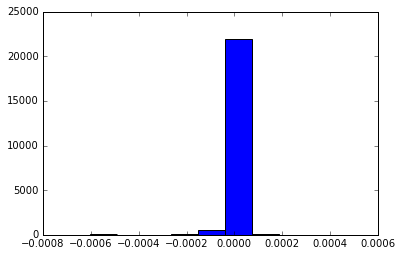

In [35]:
_ = plt.hist(dSetAdd['mu']['mVis'] - dSetAdd['mu']['mCheck'])

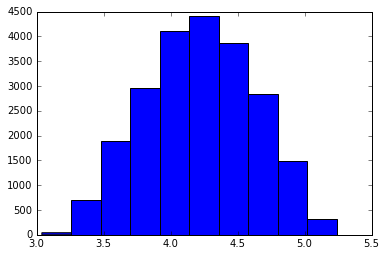

In [36]:
_ = plt.hist(np.hypot(dSetAdd['mu']['mVis'], dSetAdd['mu']['pstVis']))

0.2801027475268801
0.2740483625874916
0.24209221553719346
0.247075860120869


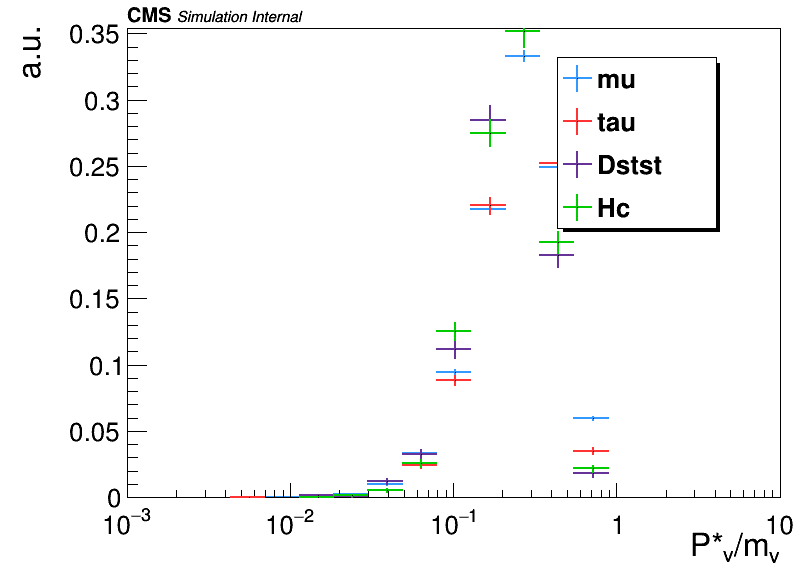

In [37]:
hl = []
leg = rt.TLegend(0.7, 0.6, 0.9, 0.9)
for n, d in dSetAdd.iteritems():
    var = d['pstVis']/d['mVis']
    h = create_TH1D(var, 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['P*_{v}/m_{v}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

0.05001258923556081
0.0461018887673335
0.036339794887852286
0.03811821058922714


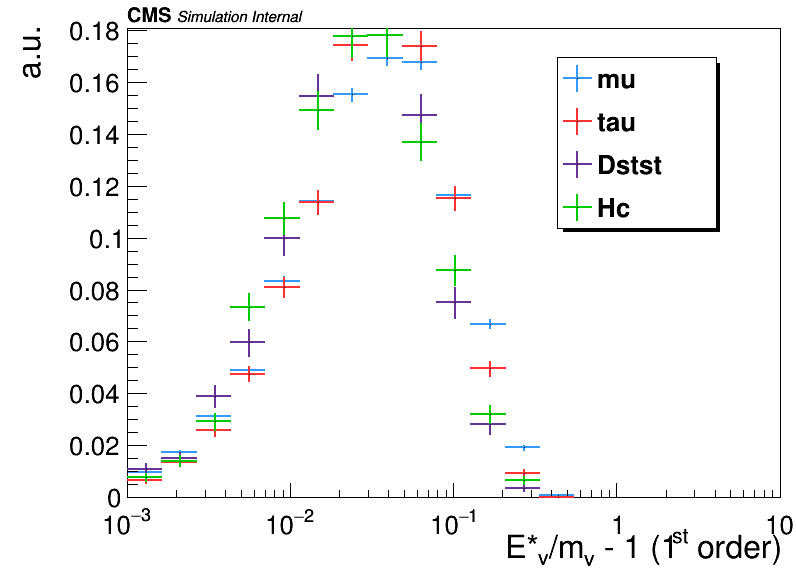

In [38]:
hl = []
leg = rt.TLegend(0.7, 0.6, 0.9, 0.9)
for n, d in dSetAdd.iteritems():
    var = 0.5*np.square(d['pstVis']/d['mVis'])
    h = create_TH1D(var, 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['E*_{v}/m_{v} - 1 (1^{st} order)', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

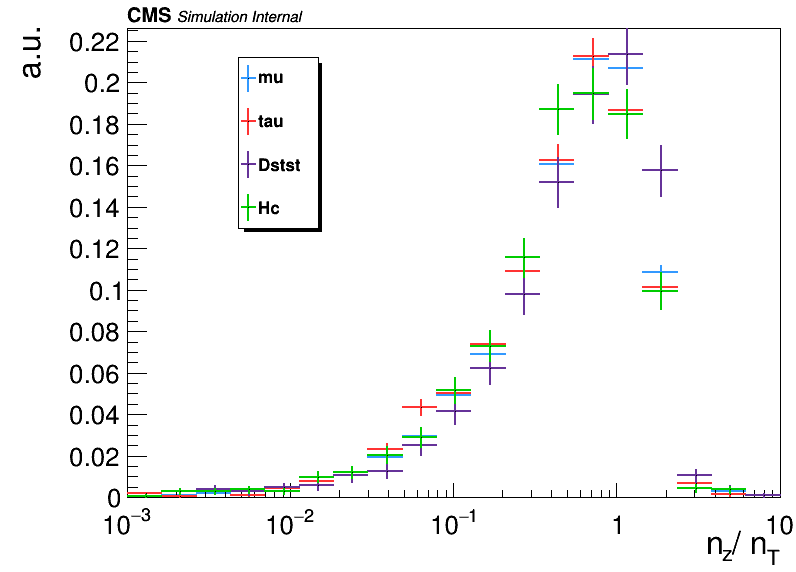

In [39]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    h = create_TH1D(d['nz']/d['nt'], 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['n_{z}/ n_{T}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

0.01522361
0.010021782
0.014118482
0.010176025


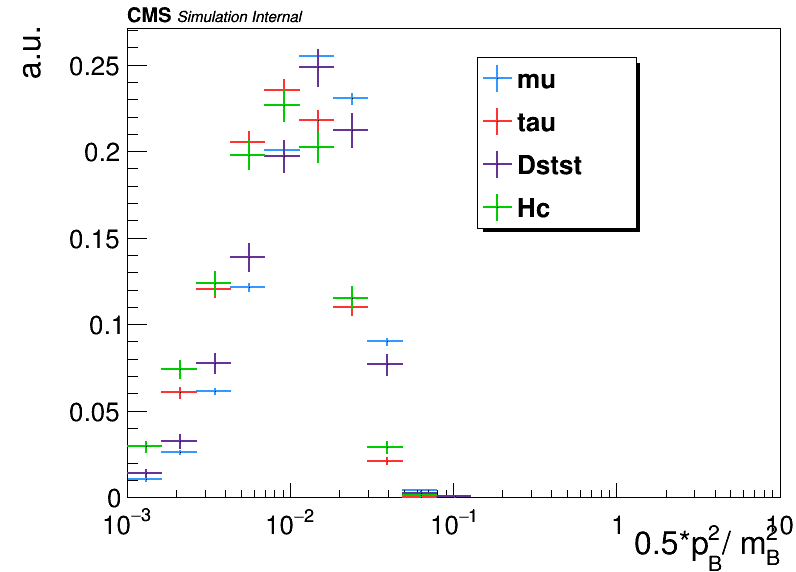

In [41]:
hl = []
leg = rt.TLegend(0.6, 0.6, 0.8, 0.9)
for n, d in dSetAdd.iteritems():
    var = 0.5*np.square(m_B0/d['B_p'])
    h = create_TH1D(var, 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['0.5*p_{B}^{2}/ m_{B}^{2}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

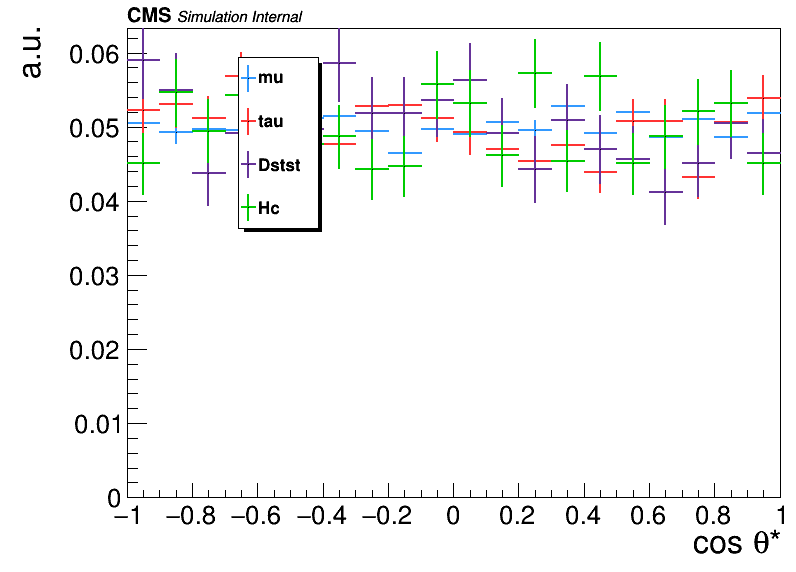

In [42]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    h = create_TH1D(d['cosTheta_st'], 
                    binning = [20, -1, 1],
                    axis_title = ['cos #theta*', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
hl[0].GetYaxis().SetRangeUser(0, 1.2*hl[0].GetMaximum())
leg.Draw()

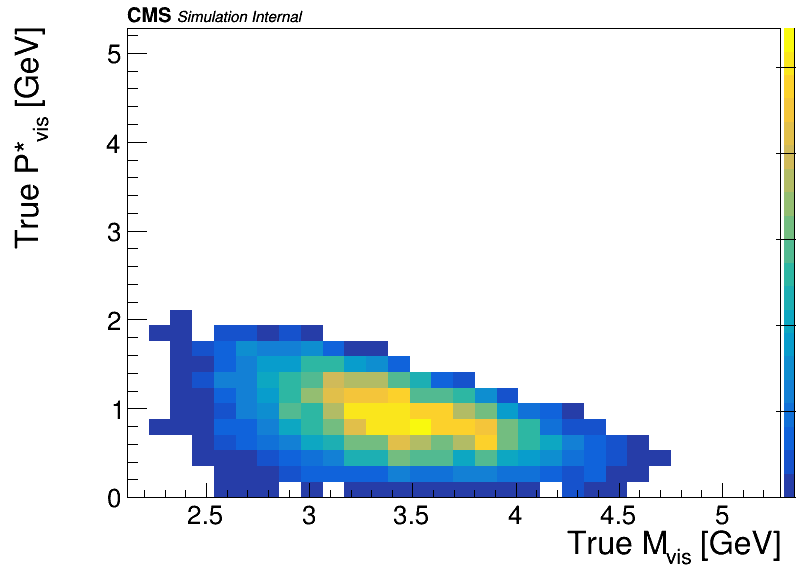

In [43]:
n = 'tau'
d = dSetAdd[n]

h = create_TH2D(np.column_stack((d['mVis'], d['pstVis'])),
                name = n,
                binning=[30, m_mu+m_Dst, m_B0, 30, 0, m_B0],
                axis_title=['True M_{vis} [GeV]', 'True P*_{vis} [GeV]', '']
               )

c =  drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.Draw()

0.05074299 0.18961297
0.041510545 0.17918473
0.028500149 0.15722016
0.037414897 0.16266924


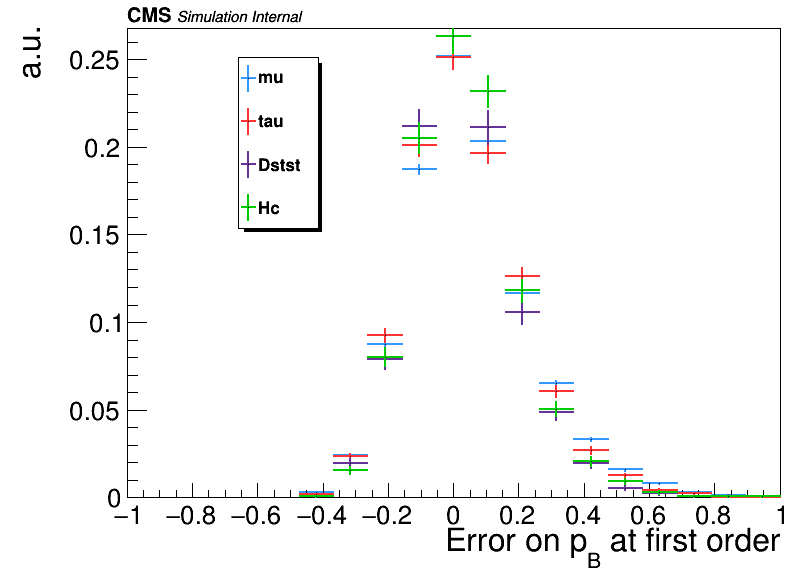

In [72]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = 1+0.5*np.square(m_B0/d['B_p'])
    var *= d['cosTheta_st']*d['pstVis']/d['mVis']
    var += 0.5*np.square(d['pstVis']/d['mVis'])
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on p_{B} at first order', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var), np.std(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
# c.SetLogx()
leg.Draw()

0.12930231 0.19805977
0.12547481 0.18726826
0.12573 0.17461066
0.07399638 0.17790444


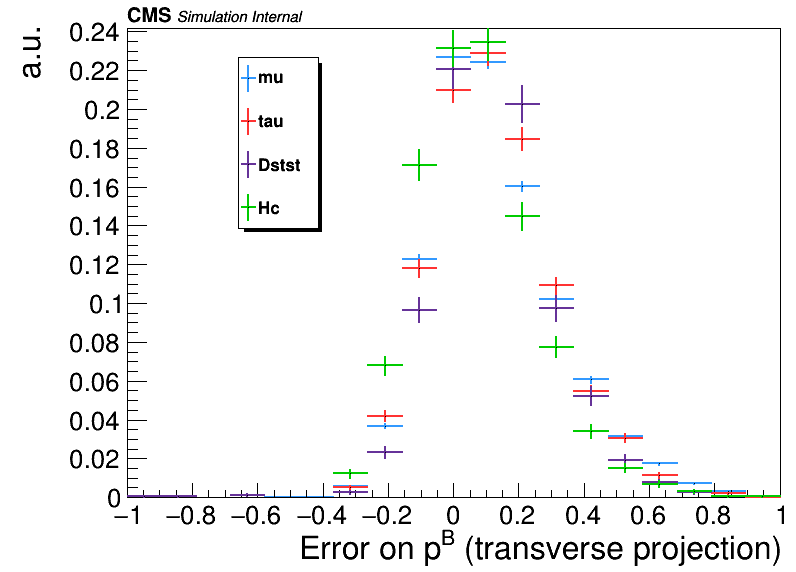

In [74]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = dSet[n]['B_pt']*np.cosh(dSet[n]['B_eta']) 
    var = (var - d['B_p'])/d['B_p']
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on p^{B} (transverse projection)', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var), np.std(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

0.1259859 0.19595453
0.12226084 0.18563192
0.12119681 0.17274402
0.0718057 0.1768594


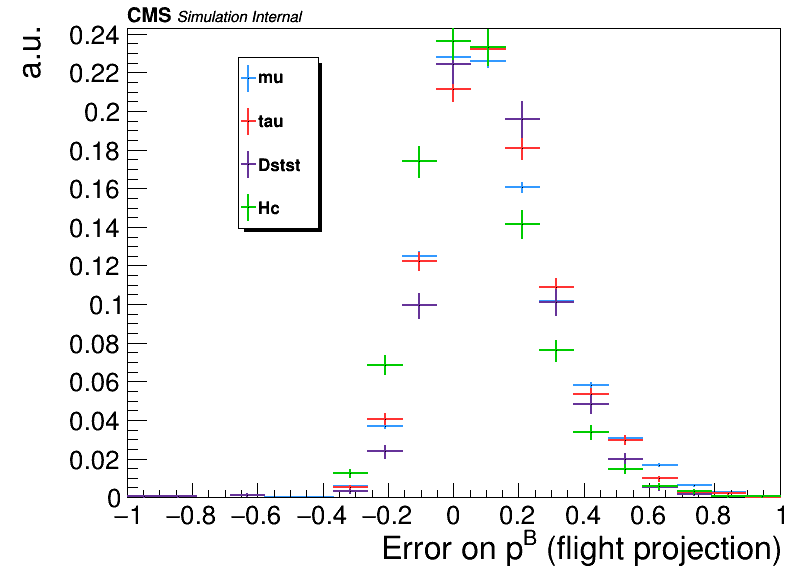

In [77]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = (d['B_p_proj']-d['B_p'])/d['B_p']
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on p^{B} (flight projection)', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var), np.std(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

0.0014193036
0.0017933835
0.0015930707
0.001335734


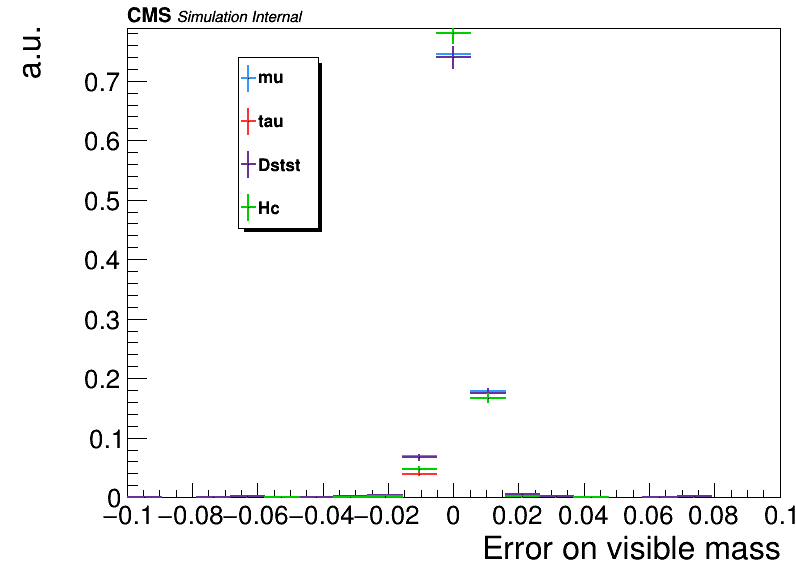

In [80]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = (d['mVis_reco']-d['mVis'])/d['mVis']
    h = create_TH1D(var, 
                    binning = np.linspace(-0.1,0.1,20),
                    axis_title = ['Error on visible mass', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

mu 0.10621097 2.0841289 -55.842926 116.31859
tau 0.0016932687 0.2002622 -1.3234645 1.3455493
Hc 0.06673135 0.33465713 -1.4671178 1.6097331
Dstst -0.0009989272 1.1332837 -2.8189373 49.824963


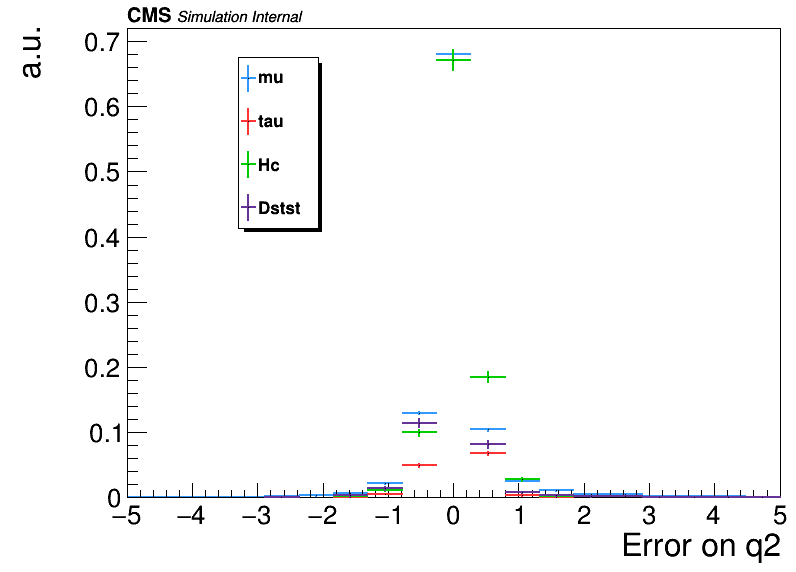

In [91]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSet.iteritems():
    var = (d['q2']-d['MC_q2'])/d['MC_q2']
    h = create_TH1D(var, 
                    binning = np.linspace(-5,5,20),
                    axis_title = ['Error on q2', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print n, np.mean(var), np.std(var), np.min(var), np.max(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

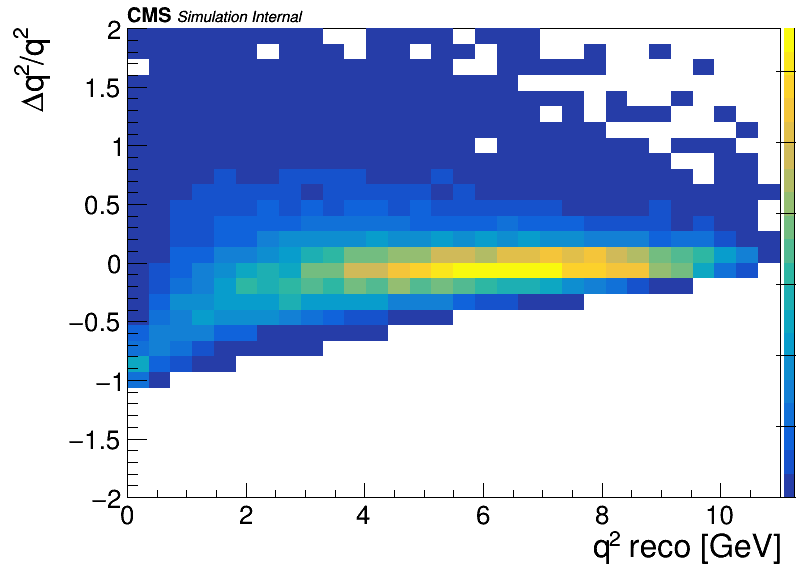

In [95]:
n = 'mu'
d = dSet[n]

var = (d['q2']-d['MC_q2'])/d['MC_q2']
h = create_TH2D(np.column_stack((d['q2'], var)),
                name = n,
                binning=[30, 0, 11, 30, -2, 2],
                axis_title=['q^{2} reco [GeV]', '#Deltaq^{2}/q^{2}', '']
               )

c =  drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.Draw()

mu 0.38301188 1.5444186 -35.751175 7.4451675
tau 0.27462342 1.3306227 -25.40403 5.7881927
Hc 0.11627629 1.4045864 -26.387627 5.78125
Dstst 0.20287919 2.3386238 -61.64502 4.3956933


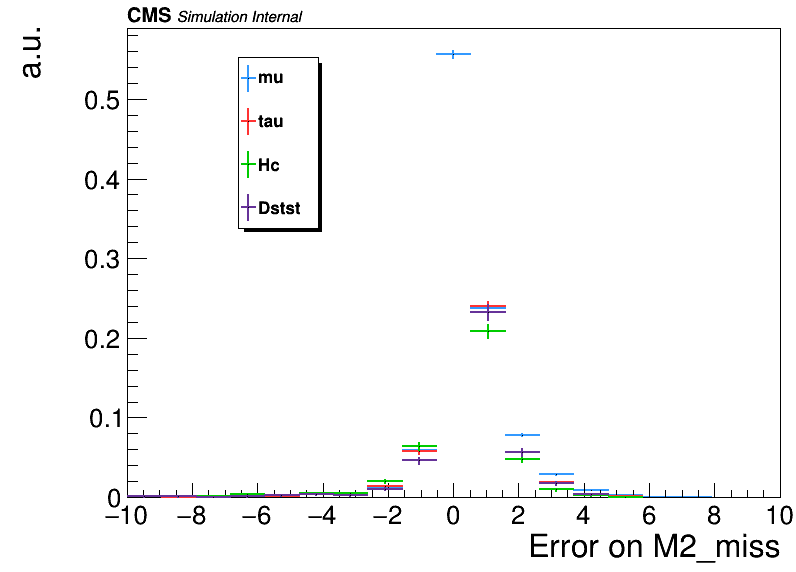

In [100]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSet.iteritems():
    var = (d['M2_miss']-d['MC_M2_miss'])
    h = create_TH1D(var, 
                    binning = np.linspace(-10,10,20),
                    axis_title = ['Error on M2_miss', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print n, np.mean(var), np.std(var), np.min(var), np.max(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

mu -0.031765513 0.114418454 -0.54050916 2.0910559
tau -0.026711255 0.11660194 -0.40344617 1.5671898
Hc 0.012674144 0.12704621 -0.7220095 1.39762
Dstst -0.029013053 0.16920619 -0.6280893 3.8048017


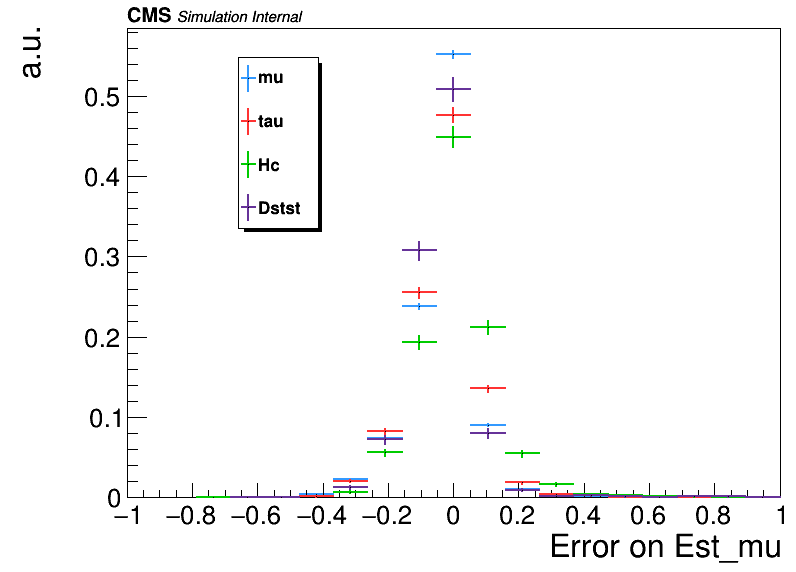

In [99]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSet.iteritems():
    var = (d['Est_mu']-d['MC_Est_mu'])/d['MC_Est_mu']
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on Est_mu', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print n, np.mean(var), np.std(var), np.min(var), np.max(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

## Uncertainty on direction

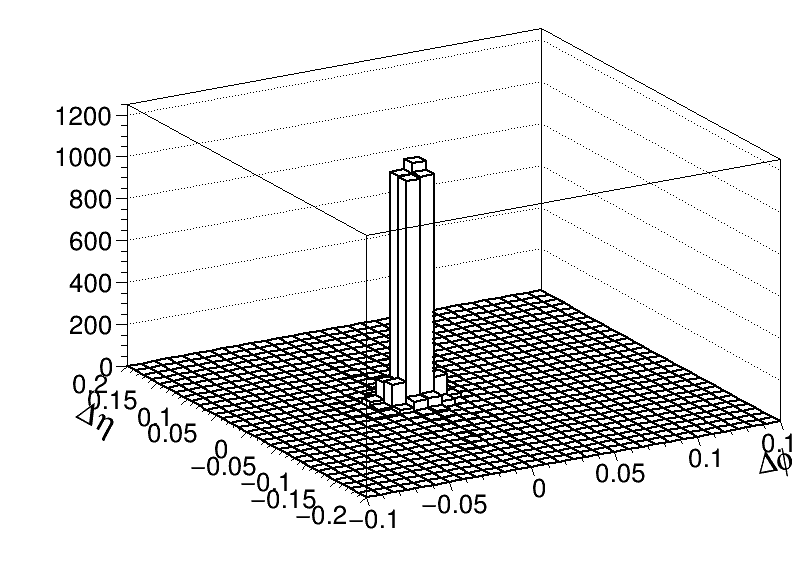

In [50]:
n = 'tau'
d = dSet[n]

dPhi = d['MC_B_phi'] - d['B_phi']
dPhi = np.where(np.abs(dPhi) > np.pi, dPhi - np.sign(dPhi)*2*np.pi, dPhi)
dEta = d['MC_B_eta'] - d['B_eta']

h = create_TH2D(np.column_stack((dPhi, dEta)),
                name = n,
                binning=[30, -0.1, 0.15, 30, -0.2, 0.2],
                axis_title=['#Delta#phi', '#Delta#eta', '']
               )

c = rt.TCanvas('c_pol', 'c_pol', 800, 600)
h.Draw('LEGO')
c.Draw()
# c.SetLogz()

In [ ]:
np.sign(-2.4)